In [21]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../src')
os.chdir('../src')

import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as idp
import librosa
import random
from raving_fader.helpers.eval import load_model,forward_eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
models_dir = "/data/nils/raving-fader/models/"
model_name = "CRAVE_combined" 
res = torch.load(os.path.join(models_dir,model_name)+"/results_analysis.pth")
res

{'distance': 22.435414594873986,
 'correlation': {'centroid': 0.8671915133004157,
  'rms': 0.8756258885855704,
  'bandwidth': 0.6028453318428091,
  'sharpness': 0.6215245051838999,
  'booming': 0.6718018543175156},
 'l1_loss': {'centroid': 0.21055032229921217,
  'rms': 0.2643559421940334,
  'bandwidth': 0.3616535480080493,
  'sharpness': 0.31564867687569004,
  'booming': 0.30056619602690676}}

In [18]:
models_dir = "/data/nils/raving-fader/models/"
model_name = "FRAVE_combined" 
res = torch.load(os.path.join(models_dir,model_name)+"/results_analysis.pth")
res

{'distance': 22.477846320059374,
 'correlation': {'centroid': 0.8628374751116595,
  'rms': 0.8771332815200624,
  'bandwidth': 0.5786031768999805,
  'sharpness': 0.6191613243422504,
  'booming': 0.6529749043537654},
 'l1_loss': {'centroid': 0.21065341919719807,
  'rms': 0.27322077712925447,
  'bandwidth': 0.38715083882301493,
  'sharpness': 0.3188945765108993,
  'booming': 0.31042385099837133}}

# Loading the dataset

In [24]:
dataset_dir = "/data/nils/datasets/nsynth_full_valid/"
sr = 16000

In [25]:
feat_path = os.path.join(dataset_dir,"features.pth")
wav_path = os.path.join(dataset_dir,"audio")
mdb_path = os.path.join(dataset_dir,"data.mdb")

all_features = torch.load(feat_path)

### Testing one wav file from the dataset

In [4]:
wav_file = os.path.join(wav_path,os.listdir(wav_path)[1007])
audio,_ = librosa.load(wav_file,sr=sr)
idp.Audio(audio,rate = sr)

### Compute the descriptors

In [44]:
from audio_descriptors.features import compute_all


def get_features(audio,descriptors,sr,latent_length=64):
    feat = compute_all(audio,sr=sr,descriptors=descriptors,
                                            mean=False,
                                            resample=latent_length)
    
    feat = {descr: feat[descr] for descr in descriptors}
    feat = np.array(list(feat.values())).astype(np.float32)
    return(torch.tensor(feat))

def plot_features(features,descriptors,features_2=None):
    f,axs = plt.subplots(1,5,figsize=(20,5))
    for i,ax in enumerate(axs):
        ax.plot(features[i],label="Original")
        
        if features_2 is not None:
            ax.plot(features_2[i],label="Modified")
        # ax.set_ylim(-1,1)
        ax.set_title(descriptors[i])
        ax.legend()
        
def normalize(features,all_features):
    features_normed = torch.clone(features)
    for i in range(features.shape[1]):
        features_normed[:,i] = 2* ( (features[:,i] - np.min(all_features[:,i])) / (np.max(all_features[:,i]) - np.min(all_features[:,i])) -0.5 ) 
    return features_normed

def compute(model,audio,features_normed,features_shifted):
    with torch.no_grad():
        x = audio.to(model.device).unsqueeze(0)
        x = model.pqmf(x)
        print(x.shape)
        z, kl = model.reparametrize(*model.encoder(x))
        print(z.shape)
        # z=torch.zeros_like(z)
        z_c = torch.cat((z, features_normed.to(model.device)), dim=1)
        y = model.decoder(z_c, add_noise=False)
        y = model.pqmf.inverse(y)
        y = y.squeeze()

        z_c = torch.cat((z, features_shifted.to(model.device)), dim=1)
        y_mod = model.decoder(z_c, add_noise=False)
        y_mod = model.pqmf.inverse(y_mod)
        y_mod = y_mod.squeeze()

        features_rec = get_features(y_mod.detach().cpu().numpy(),model.descriptors,sr=16000).unsqueeze(0)
        features_rec = normalize(features_rec,all_features)
    
    return y,z,y_mod,features_rec

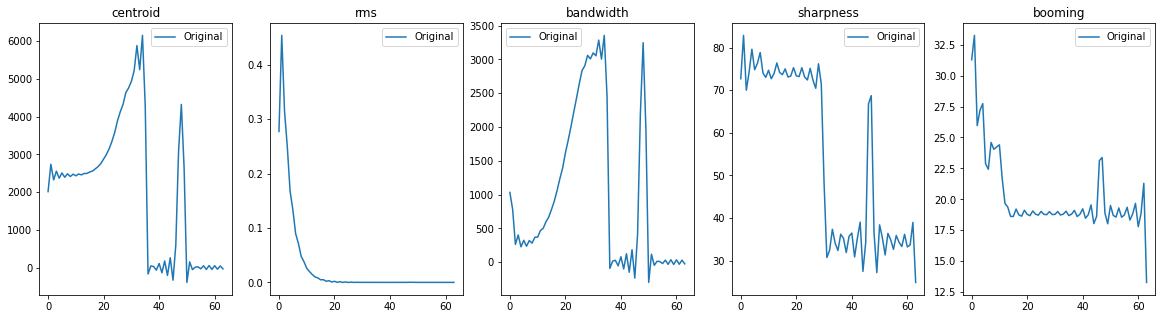

In [6]:
descriptors = ["centroid","rms","bandwidth","sharpness","booming"]
features = get_features(audio,descriptors,sr)
plot_features(features,descriptors)
idp.Audio(audio,rate = sr)

# Load models

In [22]:
models_dir = "/data/nils/raving-fader/models/"
model_name = "FRAVE_nsynthfull" 

path = os.path.join(models_dir,model_name)
ckpt = os.path.join(path,model_name+"__vae.ckpt")
config_file = os.path.join(path,"train_config.yaml")
config,pipeline,model,checkpoint=load_model(config_file,ckpt,datapath="/data/nils/datasets/nsynth_full_valid",batch_size=8)
print(checkpoint["step"])

>>> Device : cuda
15789
begin here
1016000


In [23]:
models_dir = "/data/nils/raving-fader/models/"
model_name = "CRAVE_nsynthfull" 

path = os.path.join(models_dir,model_name)
ckpt = os.path.join(path,model_name+"__vae.ckpt")
config_file = os.path.join(path,"train_config.yaml")
config,pipeline,model_c,checkpoint=load_model(config_file,ckpt,datapath="/data/nils/datasets/nsynth_full_valid",batch_size=8)
print(checkpoint["step"])

>>> Device : cuda
15789
begin here
1010000


### Load audios

In [109]:
id_wav = random.choice(range(len(os.listdir(wav_path))))
wav_file = os.path.join(wav_path,os.listdir(wav_path)[id_wav])
audio,_ = librosa.load(wav_file,sr=sr)
features = get_features(audio,model.descriptors,sr=16000).unsqueeze(0)

N = 65536
pad = (N - (len(audio) % N)) % N
audio = np.pad(audio, (0, pad))

audio = torch.tensor(audio).unsqueeze(0).to(model.device)


In [110]:
descr =None
offset = 0

features_normed = normalize(features,all_features)
features_shifted=torch.clone(features_normed)
features_shifted[:,descr] = features_shifted[:,descr]+offset


y_c,z_c,y_mod_c,features_rec_c = compute(model_c,audio,features_normed,features_shifted)
y,z,y_mod,features_rec = compute(model,audio,features_normed,features_shifted)


torch.Size([1, 8, 8192])
torch.Size([1, 128, 64])
torch.Size([1, 8, 8192])
torch.Size([1, 128, 64])


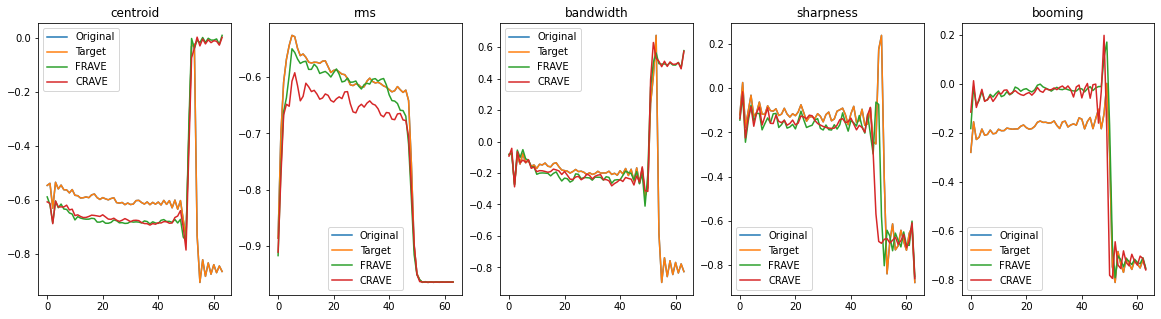

In [111]:
f,axs = plt.subplots(1,5,figsize=(20,5))
for i,ax in enumerate(axs):
    ax.plot(features_normed.squeeze()[i],label="Original")
    

    ax.plot(features_shifted.squeeze()[i],label="Target")
    ax.plot(features_rec.squeeze()[i],label="FRAVE")
    ax.plot(features_rec_c.squeeze()[i],label="CRAVE")
    # ax.set_ylim(-1,1)
    ax.set_title(model.descriptors[i])
    ax.legend()

In [108]:
idp.display(idp.Audio(audio.cpu().numpy(),rate = sr))
idp.display(idp.Audio(y.cpu().numpy(),rate = sr))
idp.display(idp.Audio(y_mod.cpu().numpy(),rate = sr))
idp.display(idp.Audio(y_mod_c.cpu().numpy(),rate = sr))

In [312]:
for x,attr in pipeline.train_set:
    # x,attr = next(iter(pipeline.train_set))
    x = x [:2]
    attr=attr[:2]
    x = x.to(model_c.device).unsqueeze(1)
    x = model_c.pqmf(x)
    z, kl = model_c.reparametrize(*model_c.encoder(x))


    attr_cls = model_c.quantify(
                        attr,
                        torch.tensor(pipeline.dataset.bin_values)).long()


    attr_cls_pred = model_c.latent_discriminator(z)
    attr_cls_pred.argmax(dim=1)

    model.get_attr_loss(attr_cls_pred.cpu(), attr_cls.cpu())
    print(model.get_attr_loss(attr_cls_pred.cpu(), attr_cls.cpu()))
    break

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.69 GiB total capacity; 814.16 MiB already allocated; 5.56 MiB free; 850.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [308]:
attr_cls_pred.shape

torch.Size([8, 16, 5, 64])

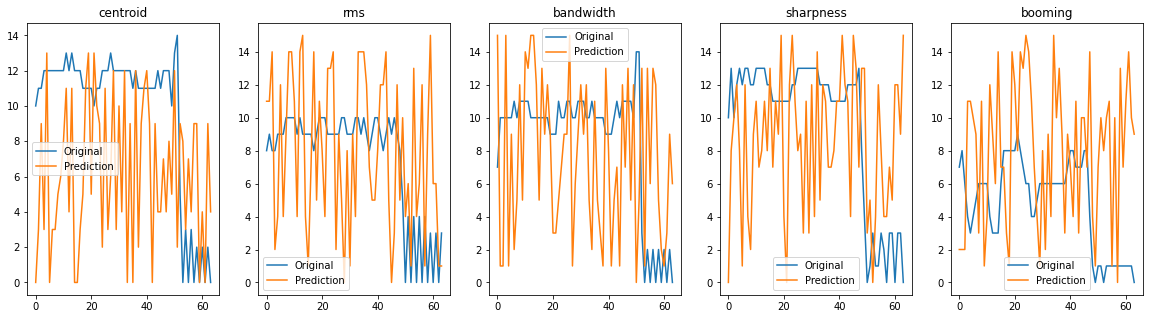

In [278]:
f,axs = plt.subplots(1,5,figsize=(20,5))
for i,ax in enumerate(axs):
    ax.plot(attr_cls.squeeze()[i],label="Original")
    ax.plot(attr_cls_pred.argmax(dim=1).squeeze().detach().cpu()[i],label="Prediction")


    # ax.set_ylim(-1,1)
    ax.set_title(descriptors[i])
    ax.legend()

In [231]:
with torch.no_grad():
    x = audio.to(model.device).unsqueeze(0)
    x = model.pqmf(x)
    print(x.shape)
    z, kl = model.reparametrize(*model.encoder(x))
    print(z.shape)
    z_c = torch.cat((z, features_normed.to(model.device)), dim=1)
    y = model.decoder(z_c, add_noise=False)
    y = model.pqmf.inverse(y)
    y = y.squeeze()

torch.Size([1, 8, 8192])
torch.Size([1, 128, 64])


In [32]:
idp.Audio(audio,rate = sr)

In [33]:
idp.Audio(y.cpu(),rate = sr)

In [139]:
all_features.max()

4328.0913